In [16]:
""" Imports and parameter setep """

%matplotlib inline

import zipline
from zipline.finance.commission import PerDollar
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, set_commission

from datetime import datetime, timedelta
import pytz
import pandas as pd
import numpy as np
import matplotlib as plt
import pyfolio as pf
from scipy import stats

path_to_data = 'K:/Share/Personal/Ryan/CFA/TradingBook/ProjectOne/'

#Parameters
start_val = 10000000
momentum_window = 126 # half a year
min_momentum_score = 40 # arbitrary number so that we only buy stocks with strong momentum
portfolio_size = 30
vol_window = 20
commission_pct = 0.0

In [2]:
""" Helper Functions """

def momentum_score(ts):
    x = np.arange(len(ts))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, np.log(ts))
    annualized_slope = (np.power(np.exp(slope),252)-1) * 100
    score = annualized_slope * (r_value **2)
    return score

def volatility(ts):
    return ts.pct_change().rolling(vol_window).std().iloc[-1]

In [22]:
""" Universe setup and trade execution """

def initialize(context):
    #set comission
    set_commission(PerDollar(cost=commission_pct))
    
    #index members file
    context.index_members = pd.read_csv(path_to_data + 'index-member-data.csv', index_col=0, parse_dates=[0])

    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open())

def rebalance(context, data):
    # get current data and index makeup on this date
    today = zipline.api.get_datetime().normalize()
    index_constituents = context.index_members.loc[context.index_members.index == today]
    todays_universe = [symbol(ticker) for ticker in index_constituents.loc[:]['BBGID']]
    
    # zipline function which gives selected history and time for given universe
    hist = data.history(assets=todays_universe, fields="close", bar_count=momentum_window, frequency="1d") 
    
    # create momentum ranking table
    ranking_table = hist.apply(momentum_score)
    ranking_table = ranking_table.sort_values(ascending=False)
    
    """ Sell Logic & Execution """
    kept_positions = list(context.portfolio.positions.keys())
    
    for security in context.portfolio.positions:
        # check if no longer in index or if momentum score has risen above threshold
        if (security not in todays_universe) or (ranking_table[security] < min_momentum_score):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
    
    """ Buy Logic """
    # check how many stocks required to take us to portfolio size
    replacement_number = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[~ranking_table.index.isin(kept_positions)][:replacement_number]
    updated_portfolio = pd.concat((buy_list, ranking_table.loc[ranking_table.index.isin(kept_positions)]))
    
    """ Buy Sizing & Execution """
    order_list = []
    for security, rank in updated_portfolio.iteritems():
        if (security in kept_positions) or (ranking_table[security] > min_momentum_score):
            order_list.append(security)
    
    if len(order_list) == 0:
        position_size = 0.0
    else:
        position_size = 1.0 / len(order_list)
    
    for security in order_list:
        order_target_percent(security, position_size)
            
def analyze(context, perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=None)

In [23]:
""" Set Dates """
start = datetime(1998, 1, 1, tzinfo=pytz.UTC)
end = datetime(2018, 12, 31, tzinfo=pytz.UTC)

Start date,1998-01-02
End date,2018-12-31
Total months,251
,Backtest
Annual return,16.3%
Cumulative returns,2275.2%
Annual volatility,25.1%
Sharpe ratio,0.73
Calmar ratio,0.32
Stability,0.92
Max drawdown,-50.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,50.54,2008-06-23,2009-03-05,2013-02-19,1217
1,44.86,2000-03-09,2002-07-23,2002-11-04,693
2,24.64,1998-07-20,1998-10-08,1999-01-28,139
3,22.67,2018-10-01,2018-12-24,NaT,NaN
4,21.30,2007-10-29,2008-03-10,2008-05-15,144


C:\Users\rlavery_lst\AppData\Local\Continuum\Anaconda2\envs\zip35\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Dotcom,0.01%,-10.37%,10.93%
Lehman,-0.51%,-7.30%,3.52%
9/11,-0.23%,-7.42%,4.92%
US downgrade/European Debt Crisis,0.11%,-7.06%,5.80%
Fukushima,0.18%,-1.93%,2.26%
US Housing,-0.57%,-3.33%,2.28%
EZB IR Event,-0.01%,-2.26%,1.60%
Aug07,0.08%,-3.45%,3.80%
Mar08,0.01%,-5.49%,4.95%
Sept08,-0.80%,-7.30%,3.52%


Top 10 long positions of all time,max
BBG000BW73T1,101.81%
BBG000BB2KW0,101.30%
BBG000F63ZX2,98.84%
BBG000BB6WG8,36.86%
BBG000CXD6X9,36.83%
BBG000M65M61,31.56%
BBG000BJDPC2,27.07%
BBG000BSBB99,27.04%
BBG000BDQGN9,26.72%
BBG000C0LW92,25.53%


Top 10 short positions of all time,max


Top 10 positions of all time,max
BBG000BW73T1,101.81%
BBG000BB2KW0,101.30%
BBG000F63ZX2,98.84%
BBG000BB6WG8,36.86%
BBG000CXD6X9,36.83%
BBG000M65M61,31.56%
BBG000BJDPC2,27.07%
BBG000BSBB99,27.04%
BBG000BDQGN9,26.72%
BBG000C0LW92,25.53%


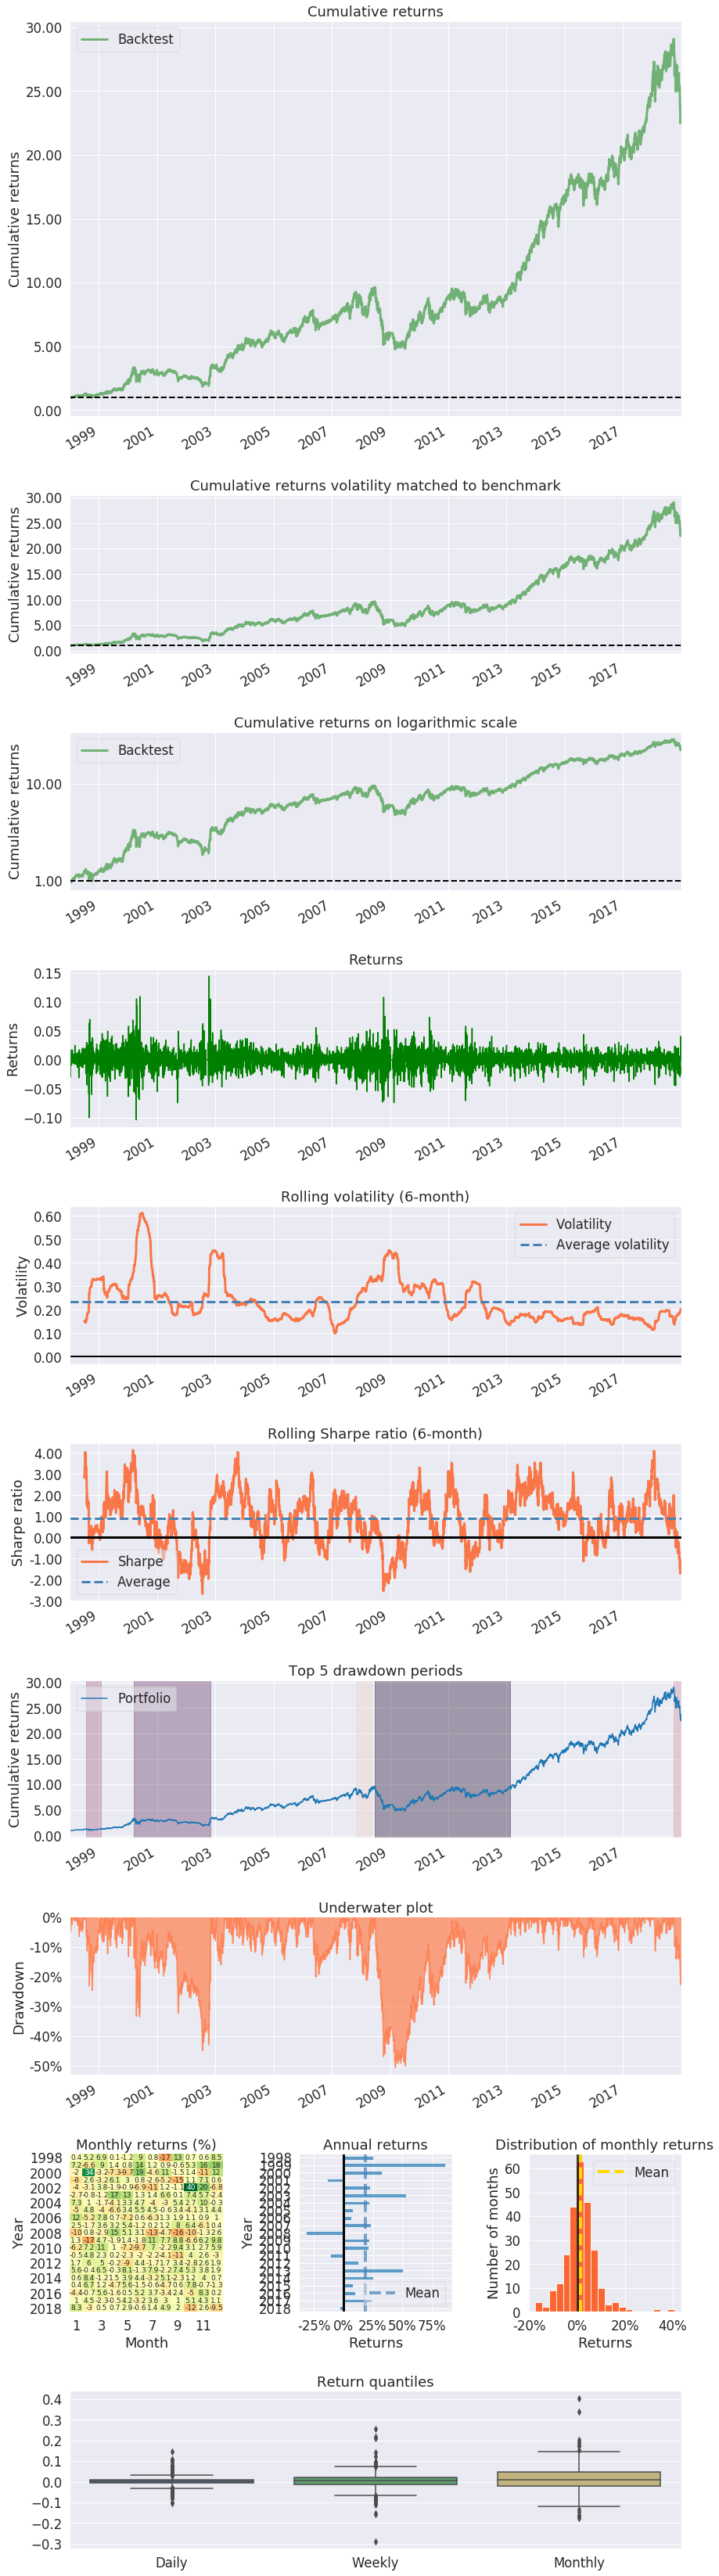

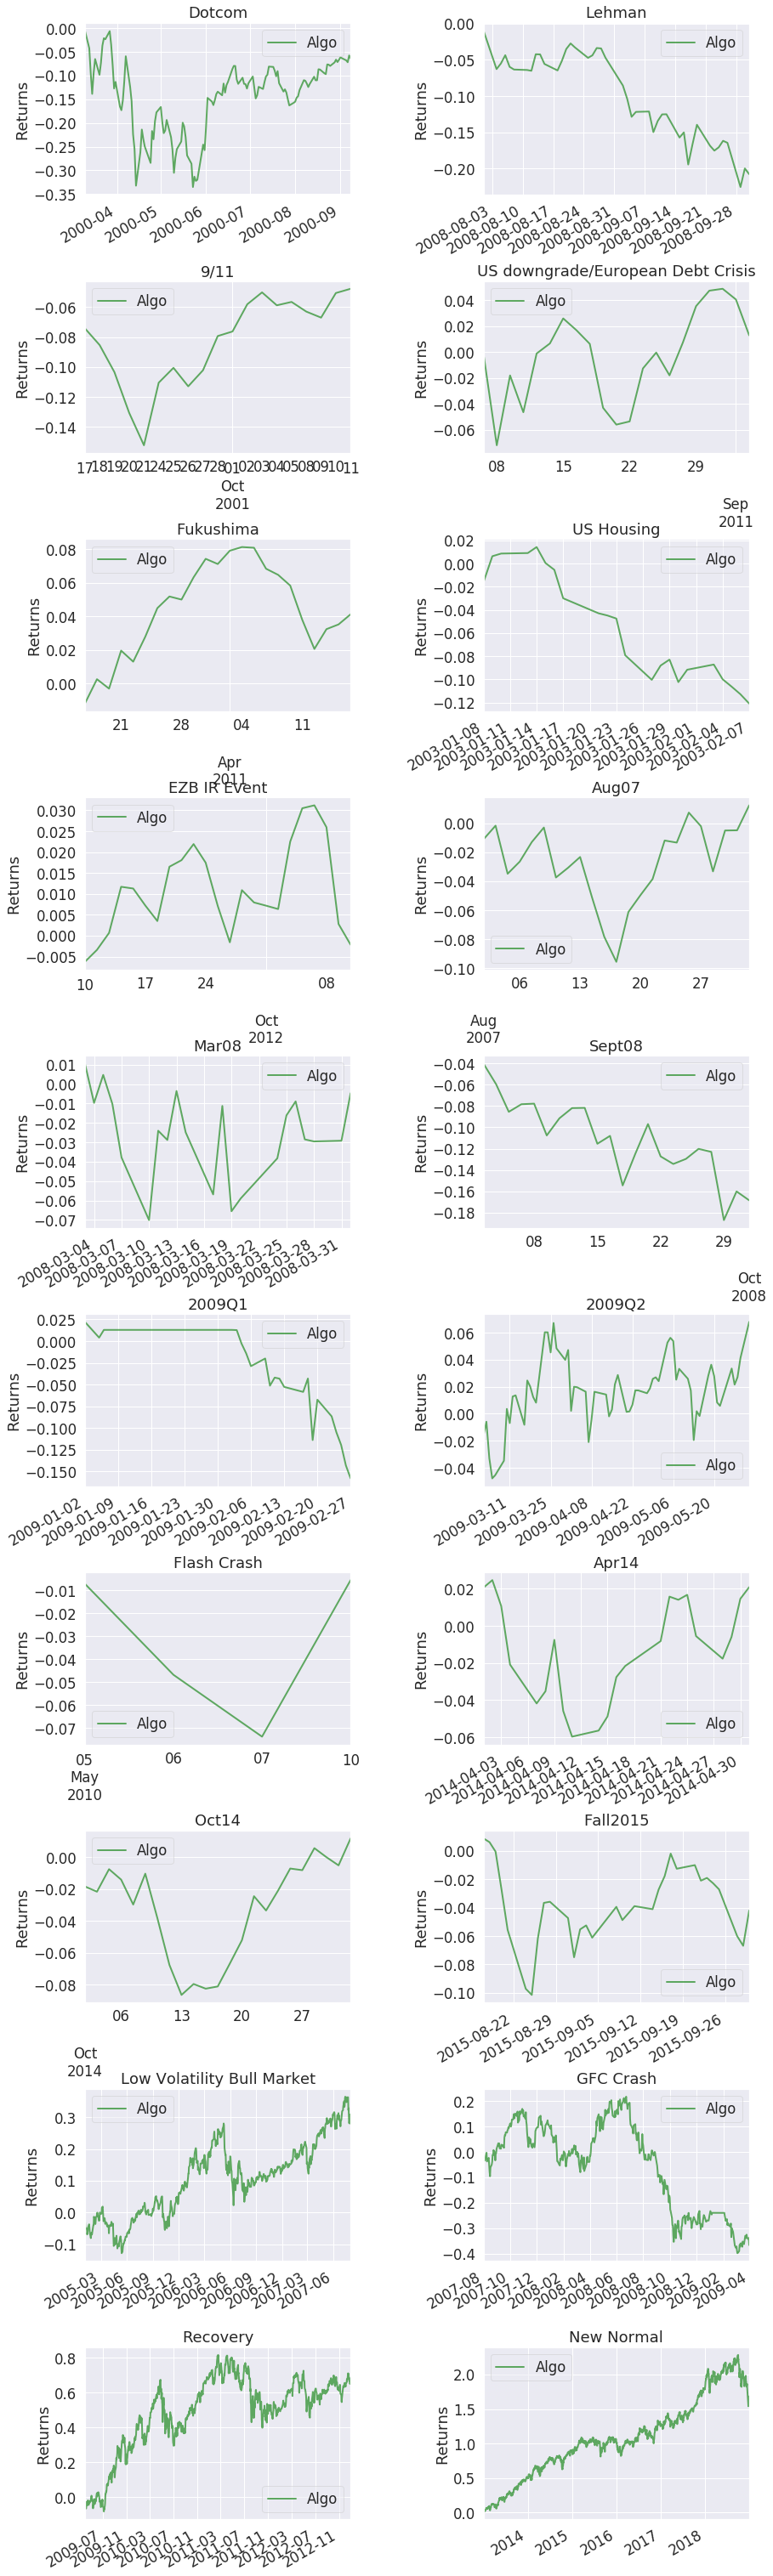

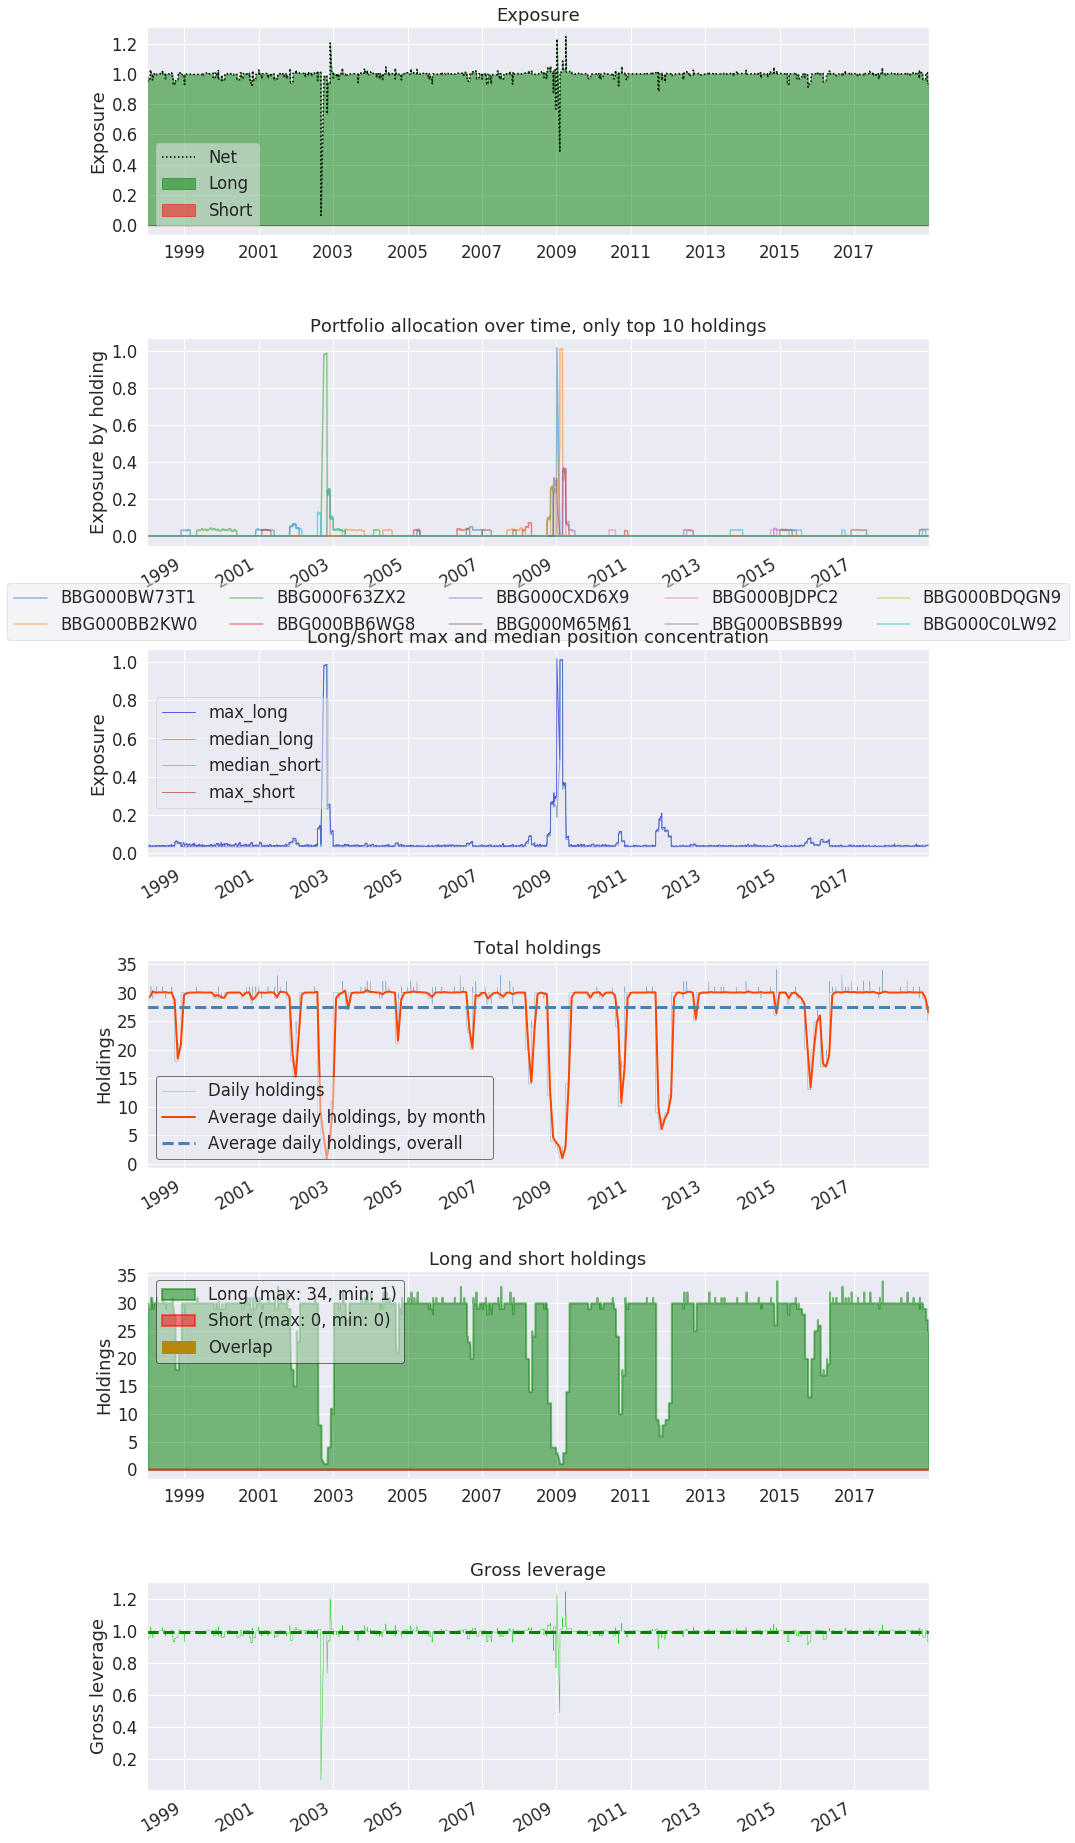

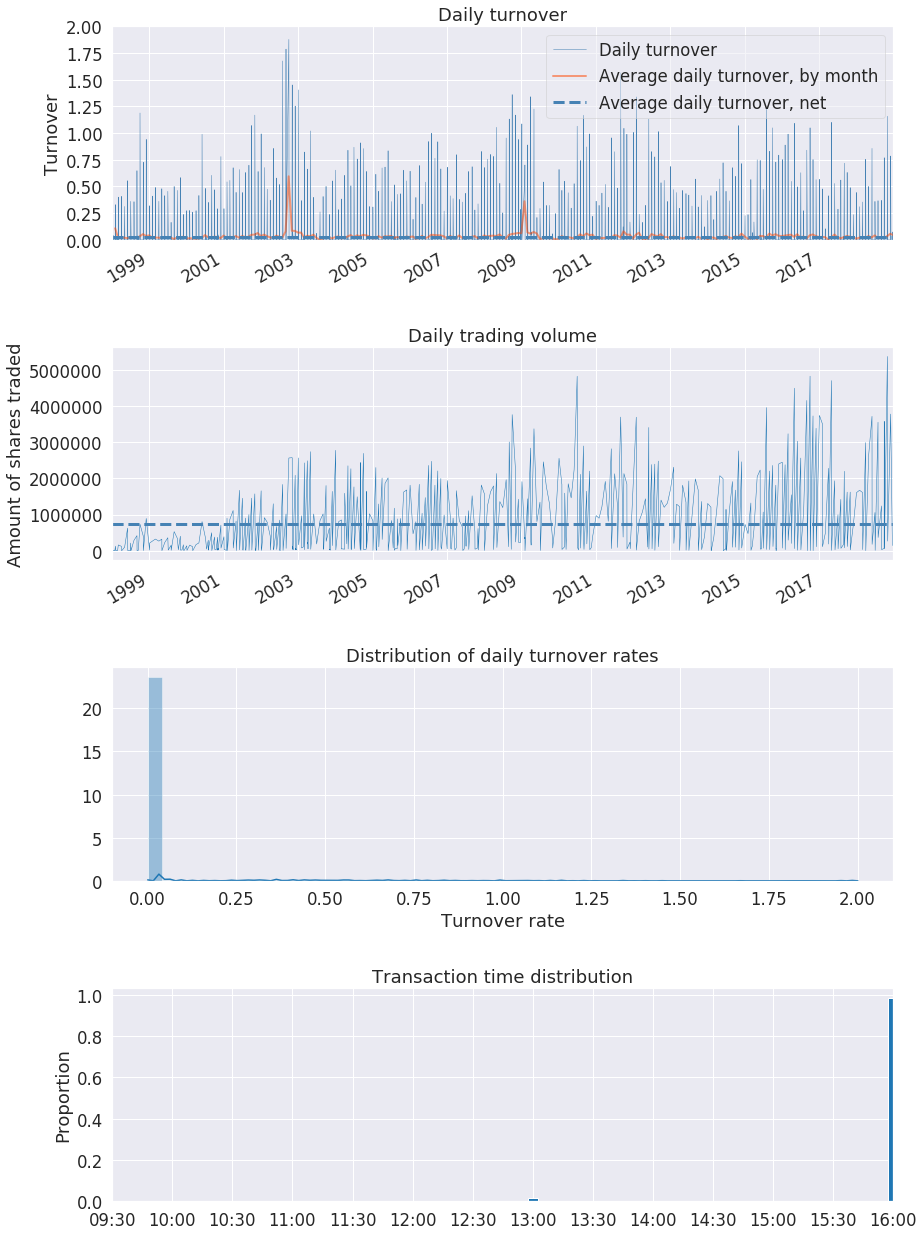

In [24]:
""" Run Backtest """
result = zipline.run_algorithm(start=start, end=end,
                               initialize=initialize,
                               analyze=analyze,
                               capital_base=start_val,
                               data_frequency='daily',
                               bundle='random_stock_data')